In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

from sklearn.metrics import confusion_matrix
import shap

In [3]:
# Load the training set data
df = pd.read_csv('../DisasterAlert/Training_set_withtime.csv')
df.head()

,Unnamed: 0,created_at,text_clean,label
0,0,2018-07-23 14:42:01,There are ways for Colorado residents to stret...,1
1,1,2018-07-23 14:20:16,RT Residents flee wildfire raging west of Athens,1
2,2,2018-07-23 14:08:16,Canada B C s Okanagan braces for more wildfires,1
3,3,2018-07-23 14:11:44,Evacuation orders as Ontario s wildfires keep ...,1
4,4,2018-07-23 08:21:09,RT How rewildling can prevent wildfires,1


In [4]:
df.drop(columns='Unnamed: 0',inplace=True)

In [5]:
# Choose X and y as training vectors
X = df['text_clean']
y = df['label']

In [6]:
X.shape

(6616,)

In [8]:
# Load the testing set
df_test = pd.read_csv('./test_data_Feb3rd_2019.csv')
df_test.head()

,date,text_clean,label
0,2019-02-03 09:00:00+00:00,Btw jgh,0
1,2019-02-03 09:00:00+00:00,New Words amp Pictures out today Follow this l...,0
2,2019-02-03 09:00:00+00:00,Weekends are made for adventures We take a fin...,0
3,2019-02-03 09:00:00+00:00,China s surge in global university rankings ha...,0
4,2019-02-03 09:00:00+00:00,4 2 days until LIGHTS OUT in Australia Six wee...,0


In [59]:
#df_test.drop(columns='Unnamed: 0',inplace =True)

In [9]:
X_test = df_test['text_clean']
X_test.shape

(173915,)

In [22]:
y_test = df_test['label']

## Use CountVectorizer

In [12]:
# Put the words with location into the stop words to get rid of the effect of them in the model fitting
from sklearn.feature_extraction import text 
stop_words_new = text.ENGLISH_STOP_WORDS.union({'greece', 'athens', 'greek'})

In [13]:
# Instantiate the CountVectorizer, fit and tranform X(training set)
cvec_new = CountVectorizer(stop_words = stop_words_new, max_features=200)
X_cvec_new = cvec_new.fit_transform(X)
X_cvec_new

<6616x200 sparse matrix of type '<class 'numpy.int64'>'
	with 14554 stored elements in Compressed Sparse Row format>

In [14]:
# Transform the test set
X_cvec_test = cvec_new.transform(X_test.values.astype('U'))

In [15]:
# after GridSearch, the best parameter in RandomForestClassifier is 'max_depth': None, 'n_estimators': 150
rf_cvec_new =RandomForestClassifier(n_estimators=150)
rf_cvec_new.fit(X_cvec_new, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [44]:
# Use cross validate, cv=10, the mean value of accuracy is 0.996
cross_val_score(rf_cvec_new, X_cvec_new, y, cv=10).mean()

0.9963732511849208

In [34]:
#print(f'The accuracy of training is {round(rf_cvec.score(X_cvec, y),3)}')
print(f'The accuracy of training with more stop words is {round(rf_cvec_new.score(X_cvec_new, y),3)}')

The accuracy of training with more stop words is 0.998


In [16]:
# predictions for test set
y_preds_test = rf_cvec_new.predict(X_cvec_test)

In [17]:
# Generate the number of positive predictions in test set
np.count_nonzero(y_preds_test == 1)

41

In [18]:
df_test['preds'] = y_preds_test

In [19]:
df_test.head()

,date,text_clean,label,preds
0,2019-02-03 09:00:00+00:00,Btw jgh,0,0
1,2019-02-03 09:00:00+00:00,New Words amp Pictures out today Follow this l...,0,0
2,2019-02-03 09:00:00+00:00,Weekends are made for adventures We take a fin...,0,0
3,2019-02-03 09:00:00+00:00,China s surge in global university rankings ha...,0,0
4,2019-02-03 09:00:00+00:00,4 2 days until LIGHTS OUT in Australia Six wee...,0,0


In [21]:
df_test['label'].value_counts()

0    173909
1         6
Name: label, dtype: int64

In [23]:
# The metrics of RandomForests for the test set
y_preds_test = rf_cvec_new.predict(X_cvec_test)
print(confusion_matrix(y_test, y_preds_test))
print('*'*30)
[[tn, fp],[fn, tp] ]= confusion_matrix(y_test, y_preds_test)
print(f'Ture Negative {tn}\n Flase Negative {fn}\n True Positive {tp} \n False Positive {fp}')

[[173874     35]
 [     0      6]]
******************************
Ture Negative 173874
 Flase Negative 0
 True Positive 6 
 False Positive 35


In [59]:
# Find the top 20 important words 
import seaborn as sns
feature_import_list = sorted(zip(map(lambda x: round(x, 4), rf_cvec.feature_importances_), names_new), reverse=True)
feature_import = feature_import_list[:20]
feature_name = []
importance_value = []
for i in range(20):
    importance_value.append(feature_import[i][0])
    feature_name.append(feature_import[i][1])
feature_name
importance_value

[0.3356,
 0.1699,
 0.1545,
 0.0704,
 0.0413,
 0.0276,
 0.0186,
 0.0149,
 0.0119,
 0.0109,
 0.0101,
 0.0091,
 0.0091,
 0.0077,
 0.0069,
 0.0068,
 0.0067,
 0.0059,
 0.0049,
 0.0042]

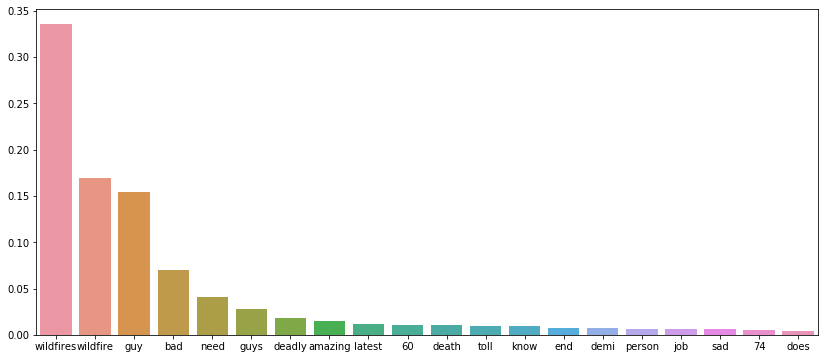

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize = (14,6))
sns.barplot(x=feature_name, y=importance_value);

In [67]:
# Use GridSearchCV to tuning the best parameters in RandomForestsClassifier
rf_params = {
    'n_estimators':[100,150,200],
    'max_depth':[None, 1,2,3,4,5]
}

gs = GridSearchCV(rf_cvec, 
                 param_grid=rf_params,
                 cv=5)

gs.fit(X_cvec, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [68]:
print(f'The best score of gridsearch is {gs.best_score_}')
print(f'The best parameter of gridsearch is {gs.best_params_}')

The best score of gridsearch is 0.99637268133168
The best parameter of gridsearch is {'max_depth': None, 'n_estimators': 150}


## Use TfidfVectorizer

In [64]:
tfidf = TfidfVectorizer(stop_words = stop_words_new, max_features=200)
X_tfidf = tfidf.fit_transform(X)
rf_tfidf = RandomForestClassifier()
rf_tfidf.fit(X_tfidf, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [65]:
cross_val_score(rf_tfidf, X_tfidf, y, cv=10).mean()

0.9960706793241039

In [66]:
print(f'The accuracy of training is {round(rf_tfidf.score(X_tfidf, y),3)}')
y_preds1 = rf_tfidf.predict(X_tfidf)
print(confusion_matrix(y, y_preds1))
print('*'*30)
[[tn, fp],[fn, tp] ]= confusion_matrix(y, y_preds1)
print(f'Ture Negative {tn}\n Flase Negative {fn}\n True Positive {tp} \n False Positive {fp}')

The accuracy of training is 0.998
[[6000    0]
 [  10  606]]
******************************
Ture Negative 6000
 Flase Negative 10
 True Positive 606 
 False Positive 0


## The accuracy of training set with different Vectorizer has no significant difference. So I choose CountVectorizer for training set